In [189]:
import pandas as pd
import numpy as np
import glob
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

## Import and Clean Up Data
#### Import data for three years of crime data by suburb and tidy up this data.  Second import household count by income bracket

In [190]:
def import_crime_data():
    
    #First three data files are crime statistics, final file is household income data
    years = ['crime-statistics-2015-16','crime-statistics-2016-17', 'crime-statistics-2017-18']
    path = r'C:\Users\Michael\Documents\Machine Learning\Courses\Uni Michigan\Plotting Course\Assignments\Assignment 4 Data\{}.xlsx'
    crimefile_dict = {year: pd.read_excel(path.format(year)) for year in years}

    keep_columns = ['Suburb - Incident', 'Offence Level 2 Description', 'Offence Count']
    
    for file in crimefile_dict:
        crimeFileIndex = crimefile_dict[file][keep_columns]
   
    #Groups data by suburb then offence type and sums number of offences for each category.  Finaly sorts on suburb name.
    crimeFileIndex = (crimeFileIndex.groupby(['Suburb - Incident', 'Offence Level 2 Description']).agg({'Offence Count':'sum'})
                    .sort_values('Suburb - Incident'))
    
    #Calculates the average annual number of offences
    crimeFileIndex['Offence Count'] = crimeFileIndex['Offence Count'] / len(crimefile_dict)

    return crimeFileIndex 


def import_income_data():
    data_file4 = open(r'C:\Users\Michael\Documents\Machine Learning\Courses\Uni Michigan\Plotting Course\Assignments\Assignment 4 Data\tablebuilder-dependent-children-by-suburb-by-income-band-sa-22052013.xlsx', 'rb')
    income_data = pd.read_excel(data_file4, skiprows = 5, header = None, skipinitialspace=True)
    
    #Clean up income data.  Changes heading and extracts suburb data for total household and oneparent household income data
    income_data.loc[0] = income_data.loc[0].ffill(axis=0)
    income_data.fillna("", inplace = True)
    headers = income_data.iloc[0]
    income_data  = pd.DataFrame(income_data.values[1:], columns=headers)
    income_data.set_index(income_data.columns[0], inplace = True)
    last_row = income_data.index.get_loc('Total')
    income_data = income_data.iloc[0:last_row,]
    income_data = income_data.filter(regex ='One parent|Total')
    income_data.iloc[0] = (income_data.iloc[0].str.replace(r"\s+\(.*\)","")
                           .str.replace('$', '$\$$'))
    
    #Removes text between () and converts suburb names to all lowercase for merging
    income_data = income_data.reset_index()
    income_data.iloc[:,0] = income_data.iloc[:,0].str.replace(r"\s+\(.*\)","")
    income_data.iloc[:,0] = income_data.iloc[:,0].str.lower()
    
    return income_data



#### Extract key data from crime file (total offence count by suburb).  Could filter by crime type in the future if required

In [191]:
def consolidate_crimedata():
    crimeFileIndex = import_crime_data()
    crimeFileSummary = crimeFileIndex.sum(level = 'Suburb - Incident').reset_index()
    crimeFileSummary['Suburb - Incident'] = crimeFileSummary['Suburb - Incident'].str.lower()
    crimeFileSummary.rename(columns={'Suburb - Incident':'Suburb'}, inplace=True)
    
    #Alternate way to sum using unstack index
#     crimeFileIndex = crimeFileIndex.unstack(level=-1)
#     crimeFileIndex["Total Crime"] = crimeFileIndex.sum(axis = 1)
#     crimeFileSummary = crimeFileIndex["Total Crime"]
    
    return crimeFileSummary


#### Import household income data and calculate percentage of households earning less than 60% of median Aust income (c. $35,000)

In [192]:
def household_poverty():
    income_data = import_income_data()
    income_data.columns = pd.MultiIndex.from_arrays([income_data.columns,income_data.iloc[0]])
    income_data = income_data.iloc[1:,]
    income_summary = income_data.groupby(level=0, axis=1).sum()
    income_summary.columns = ['Suburb','One Parent All','Total All']
    
    low_income = ['suburbs','Negative income','Nil income','$\$$1-$\$$199','$\$$200-$\$$299','$\$$300-$\$$399',
                   '$\$$400-$\$$599','$\$$600-$\$$799']
        
    low_income_data = income_data.loc(axis=1)[pd.IndexSlice[:, low_income]].groupby(level=0, axis=1).sum()
    low_income_data.columns = ['Suburb','One Parent Low Income','Total Low Income']
    
    
    return income_summary, low_income_data



#### Merge the low income data with the crime statistics data

In [193]:
def merge_data():
    
    income_summary, low_income_data = household_poverty()
    crimeFileSummary = consolidate_crimedata()
    
    data_frames = [income_summary, low_income_data, crimeFileSummary]
    
    df_merged_inner = reduce(lambda  left,right: pd.merge(left,right,on=['Suburb'],
                                            how='inner'), data_frames)
    
    return df_merged_inner
    

#### Calculations and plotting of key information

<IPython.core.display.Javascript object>


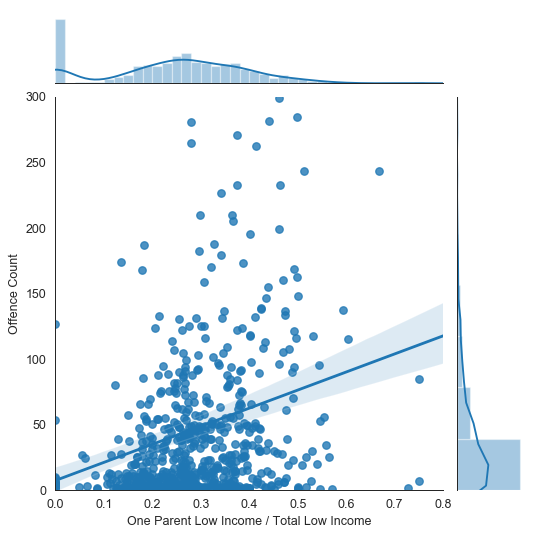

In [198]:
def plot_data():
    df_merged_inner = merge_data()
    df_merged_inner['One Parent Low Income / Total Low Income'] = (df_merged_inner['One Parent Low Income'] 
                                                      / df_merged_inner['Total Low Income'])
    
    df_merged_inner['Total Low Income / All'] = (df_merged_inner['Total Low Income'] 
                                                      / df_merged_inner['Total All'])
    
    df_merged_inner['One Parent / All'] = (df_merged_inner['One Parent All'] 
                                                      / df_merged_inner['Total All'])
    
    column_extract =  ['Suburb','One Parent Low Income / Total Low Income',
                      'Total Low Income / All', 'One Parent / All','Offence Count']
    
    return df_merged_inner[column_extract]

def jointplot_data():
    df_merged_inner = plot_data()
    
    #Seaborn join plot of data   
    sns.set_style('white')
    #Using scatter plot
#     plot = sns.jointplot(df_merged_inner['One Parent Low Income Ratio'], df_merged_inner['Offence Count'], 
#                          marginal_kws=dict(bins=50, rug=False),  s=40, edgecolor="w", linewidth=1,
#                          alpha=0.4, kind = 'scatter');
    #Using regression
    plot = sns.jointplot(df_merged_inner['One Parent Low Income / Total Low Income'], df_merged_inner['Offence Count'], 
                         marginal_kws=dict(bins=50, rug=False), kind = 'reg');
    
    plot.ax_marg_x.set_xlim(0, 0.8)
    plot.ax_marg_y.set_ylim(0, 300)
    
def corrplot_data():    
    
    df_merged_inner = plot_data()
    #Pairplot with scatter
    sns.pairplot(df_merged_inner, kind="scatter", plot_kws=dict(s=50, edgecolor="white", linewidth=1))
    #Pairplot with regression line added
    sns.pairplot(df_merged_inner, kind="reg")

    plt.show()
    
    
jointplot_data()    
    
    
    